In [1]:
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.constants import h, c

from synphot import SourceSpectrum, Observation

from matplotlib import pyplot as plt

import numpy as np
from specutils import Spectrum1D

import uvex_etc
UVEX = uvex_etc.config.UVEX()

from uvex_etc import zodi, galactic, lyman, filters
from importlib import reload
reload(filters)
# Convenience
area = UVEX.AREA

# Imaging bandpasses
nuv_band = filters.nuv_bandpass()
fuv_band = filters.fuv_bandpass()


# Spectrometer bins and bandpass
spec_bins = filters.lss_wave()
spec_band = filters.lss_bandpass()


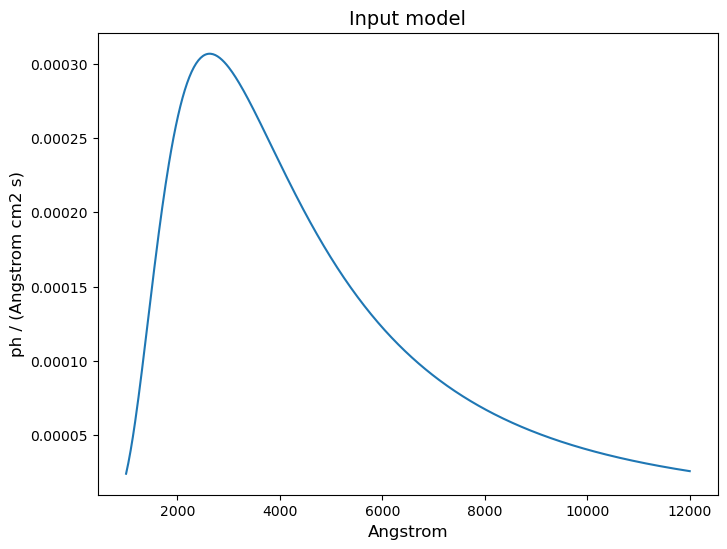

In [2]:
# Preprocess model
# Put source at 100 Mpc
# Your model will vary here

data = np.genfromtxt('./example_data/shock_6hr.dat', skip_header=6)
wave = data[:, 1] * u.AA
flux = data[:, 2] 
ph_energy = (h * c / wave).to(u.erg).value

# Original was 40 Mpc
#d = 40 *u.Mpc
#target_dist = 100 * u.Mpc
#scale = (d / target_dist)**2
scale = 1.0

ph_flux = scale*(flux / ph_energy)*(u.ph / u.cm**2 / u.s / u.AA)

# Convert this to a Spectrum1D model
model = Spectrum1D(flux=ph_flux, spectral_axis= wave)

ax = plt.figure(figsize=(8, 6)).subplots()
ax.plot(wave, ph_flux)
ax.set_ylabel(ph_flux.unit, fontsize=12)
ax.set_xlabel(wave.unit, fontsize=12)
ax.set_title('Input model', fontsize=14)
plt.show()

In [3]:
# Load backgrounds

# Pick some random field
ra = 197.6898587
dec = 8.5678292

# Pic an observation date
obstime = Time('2021-06-10 09:00:00')

# Create SkyCoord object, coords in GeocentricTrueEcliptic frame
coord = SkyCoord(ra*u.deg,
                  dec*u.deg,
                  obstime=obstime, frame='icrs').transform_to("geocentrictrueecliptic")
gal = coord.galactic
radec = coord.icrs
print(f'Galactic latitude: {gal.b:8.2f}')

Galactic latitude:    70.88 deg


In [4]:
# Statistics for the NUV band
band = 'NUV'

galactic_spec = galactic.galactic_nuv_spec(gal.b)
print(band)
print()
zodi_spec = zodi.zodi_spec_coords(radec, obstime, diag=True)

# Create observations
nuv_zodi = Observation(zodi_spec, nuv_band)
nuv_galactic = Observation(galactic_spec, nuv_band)

sky = nuv_zodi.countrate(area=area) + nuv_galactic.countrate(area=area)
obs_nuv = Observation(model, nuv_band)
source = obs_nuv.countrate(area=area)
dt = uvex_etc.get_exposure(source, sky)

print()
print(f'Flux density: {obs_nuv.effstim(u.ABmag):8.2f}')
print(f'Estimated count rate: {source:8.2f}')
print(f'Sky count rate: {sky:8.2e}')
print(f'Time to achieve 5-sigma {dt:8.2f} (sec)')

NUV

zodi_spec_coords:
Ecliptic lat/lon:    14.85 /   113.53
Zodi scale: [161.45352542]

Flux density:    17.13 mag(AB)
Estimated count rate:   102.87 ct / s
Sky count rate: 9.57e-03 ct / s
Time to achieve 5-sigma     0.45 (sec)


In [5]:
# Statitics for the FUV band
band = 'FUV'

galactic_spec = galactic.galactic_fuv_spec(gal.b)
print(band)
print()
zodi_spec = zodi.zodi_spec_coords(radec, obstime, diag=True)


# Create observations
fuv_zodi = Observation(zodi_spec, fuv_band, force = 'extrap')
fuv_galactic = Observation(galactic_spec, fuv_band, force = 'extrap')

sky = fuv_zodi.countrate(area=area) + fuv_galactic.countrate(area=area)


obs_fuv = Observation(model, fuv_band, force='extrap')
source = obs_fuv.countrate(area=area)
dt = uvex_etc.get_exposure(source, sky)

print()
print(f'Flux density: {obs_fuv.effstim(u.ABmag):8.2f}')
print(f'Estimated count rate: {source:8.2f}')
print(f'Sky count rate: {sky:8.2e}')
print(f'Time to achieve 5-sigma {dt:8.2f} (sec)')

FUV

zodi_spec_coords:
Ecliptic lat/lon:    14.85 /   113.53
Zodi scale: [161.45352542]

Flux density:    18.18 mag(AB)
Estimated count rate:    28.27 ct / s
Sky count rate: 9.42e-04 ct / s
Time to achieve 5-sigma     1.65 (sec)


# Spectrometer Example

In [6]:
# Spectrometer, using specutils:
# Build the observation and get binned counts per second sampled at the spectrometer pixel locations
obs = Observation(model, spec_band, binset=spec_bins, force='extrap')
binflux = obs.sample_binned(flux_unit='count', area=area) 

# Let 1 hour be the exposure time and see what the expected number of counts per pixel is:

exposure = 1800*u.s
ctsflux = binflux * exposure

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


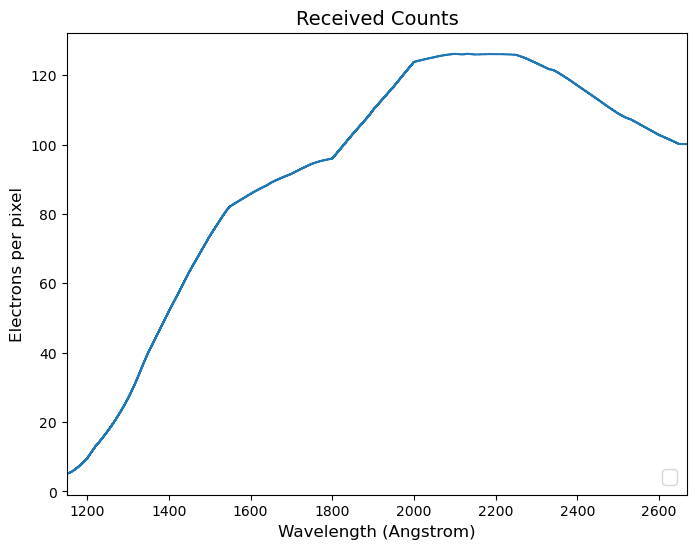

In [7]:
# Expected counts per pixel 

# Plot results
ax = plt.figure(figsize=(8, 6)).subplots()
ax.plot(spec_bins, ctsflux, drawstyle='steps-mid')
ax.set_xlabel('Wavelength (Angstrom)', fontsize=12)
ax.set_ylabel('Electrons per pixel', fontsize=12)
ax.legend(loc='lower right', numpoints=1, fontsize=14)
ax.set_xlim(spec_bins.min().value, spec_bins.max().value)
ax.set_title('Received Counts', fontsize=14)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


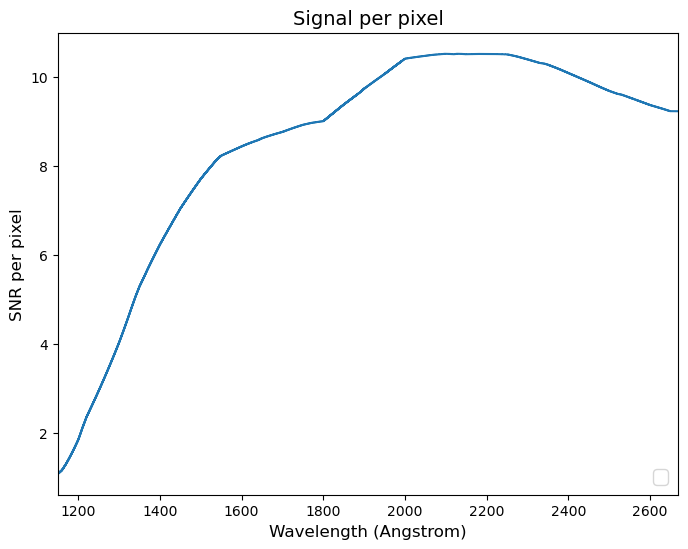

In [8]:
# Estimate the SNR per pixel

sky = 0 * binflux.unit # Set the sky background to zero here

snr = uvex_etc.get_snr(exposure,binflux,sky,npix=3)

ax = plt.figure(figsize=(8, 6)).subplots()
ax.plot(spec_bins, snr, drawstyle='steps-mid')
ax.set_xlabel('Wavelength (Angstrom)', fontsize=12)
ax.set_ylabel('SNR per pixel', fontsize=12)
ax.legend(loc='lower right', numpoints=1, fontsize=14)
ax.set_xlim(spec_bins.min().value, spec_bins.max().value)
ax.set_title('Signal per pixel', fontsize=14)
plt.show()

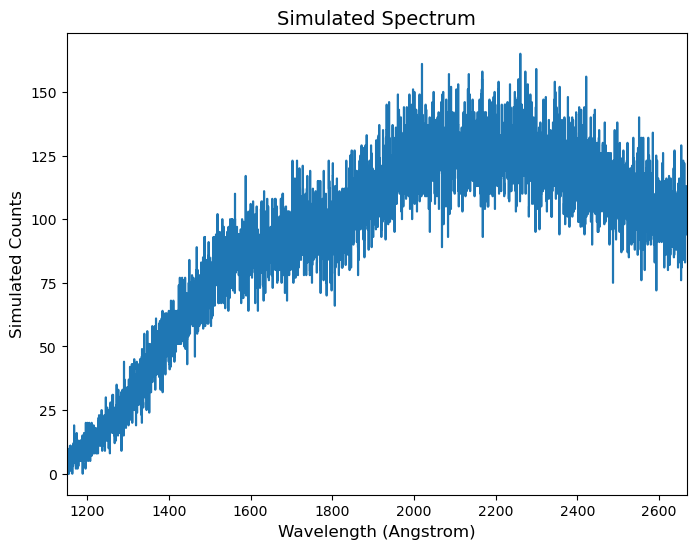

In [9]:
# Look at what an actual spectrum would look like
countspec = filters.make_lss_spectrum(binflux.value, exposure = exposure)
ax = plt.figure(figsize=(8, 6)).subplots()
ax.plot(spec_bins, countspec, drawstyle='steps-mid')
ax.set_xlabel('Wavelength (Angstrom)', fontsize=12)
ax.set_ylabel('Simulated Counts', fontsize=12)
#ax.legend(loc='lower right', numpoints=1, fontsize=14)
ax.set_xlim(spec_bins.min().value, spec_bins.max().value)
ax.set_title('Simulated Spectrum', fontsize=14)
plt.show()